# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
#os.chdir("/data2/mito_lineage/")#Analysis/multiplex")

### Remove this when running in snakemake

## 1.1 Parameters

In [4]:
DEBUG=True
INDIR= "/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor"
OUTDIR = "/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20" 
#N_DONORS = 4 
nclones = 20
donor = 0

n_cores=4
# INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/"
# OUTDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/clones"
# N_DONORS=2
# #donor = 0
# #n_clone_list="20,40,100"#[20, 40, 100]
# nclones=20

In [5]:
nclones = int(nclones)
# n_clone_list = [int(x) for x in n_clone_list.split(",")]
# n_clone_list

## 1.2 Import packages

In [6]:
from os.path import join, exists, dirname
from icecream import ic
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
ic(vireoSNP.__version__)
from tqdm import tqdm
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2
from src.vireo.vireo_utils import run_lineage
#np.set_icoptions(formatter={'float': lambda x: format(x, '.5f')})

ic| vireoSNP.__version__: '0.5.6'


In [7]:
if not DEBUG:
    ic.disable()


# 2 Lineage construction for each donor

In [8]:
cells_meta = pd.read_csv(join(INDIR, f"cells_meta.tsv"), sep='\t')

cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGAGGTCCA-1_Control,AAACGAAAGAGGTCCA-1,1,Control,1,1
1,1,AAACGAAAGCGATACG-1_Control,AAACGAAAGCGATACG-1,2,Control,3,1
2,2,AAACGAAAGTCGTGAG-1_Control,AAACGAAAGTCGTGAG-1,3,Control,0,1
3,3,AAACGAACAATAGTGA-1_Control,AAACGAACAATAGTGA-1,4,Control,1,2
4,4,AAACGAACACAATAAG-1_Control,AAACGAACACAATAAG-1,5,Control,0,2
...,...,...,...,...,...,...,...
17398,17398,TTTGTGTTCGAGTTAC-1_Flt3l,TTTGTGTTCGAGTTAC-1,17399,Flt3l,0,4204
17399,17399,TTTGTGTTCGCATAAC-1_Flt3l,TTTGTGTTCGCATAAC-1,17400,Flt3l,<NA>,<NA>
17400,17400,TTTGTGTTCGTGGTAT-1_Flt3l,TTTGTGTTCGTGGTAT-1,17401,Flt3l,3,3852
17401,17401,TTTGTGTTCGTTACAG-1_Flt3l,TTTGTGTTCGTTACAG-1,17402,Flt3l,1,3749


In [9]:
INDIR

'/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor'

ic| curr_ad_f: '/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/cellSNP.tag.AD.mtx'
ic| curr_dp_f: '/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/cellSNP.tag.DP.mtx'
ic| curr_vcf.head():   #CHROM  POS   REF ALT  strand_correlation       vmr  n_cells_over_5  \
                     0   chrM   49   49A   G            0.858809  0.045389              17   
                     1   chrM   64   64C   T            0.977866  0.123484             144   
                     2   chrM  103  103G   A            0.813456  0.090167              10   
                     3   chrM  146  146T   G            0.973922  0.072806              19   


[-406175.25137638825, -404862.5368838238, -407682.6410472898, -405418.73395854526, -406512.1689322158, -405256.62182846165, -407880.8831316929, -405062.35340976296, -408307.70417541906, -404924.4433304237, -403763.0547853203, -409456.2462068584, -407366.5524067043, -406302.5126626305, -407604.7385747839, -404810.75094408763, -407687.4510642687, -407970.19896467496, -407775.271131483, -409113.02250855416, -405489.218709346, -406491.6024008645, -407031.91097064374, -406261.36348156, -405759.90646944975, -405189.9024509456, -408038.49883727694, -405187.3387648385, -403067.5808292923, -406418.1925353175, -407732.73277363076, -407454.8749294805, -408954.85943178507, -404341.57618489175, -406233.51711038593, -405216.00878519774, -405631.8689745589, -406595.9749612616, -406933.38006254414, -407698.890621837, -404836.11196471064, -406025.6420739163, -406625.16981426463, -408533.1102917765, -407200.940366313, -404776.9778293972, -405429.3223123925, -408342.9577240809, -406110.14920370816, -4032

ic| 'Before filtering'
ic| cells_meta.shape: (4199, 7)
ic| 'After filtering'
ic| cells_meta.shape: (4199, 8)
ic| allAD.shape: (229, 4199)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic|

lineage 0: 130 cells 
(1406, 3)
(1406, 3)
donor0_lineage0
lineage 1: 380 cells 
(3827, 3)
(3827, 3)
donor0_lineage1
lineage 2: 3 cells 
(98, 3)
(98, 3)
donor0_lineage2


 cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 

lineage 3: 57 cells 
(705, 3)
(705, 3)
donor0_lineage3
lineage 4: 218 cells 
(2632, 3)
(2632, 3)
donor0_lineage4
lineage 5: 175 cells 
(1799, 3)
(1799, 3)
donor0_lineage5


10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)


lineage 6: 0 cells 
(0, 3)
(0, 3)
donor0_lineage6
lineage 7: 59 cells 
(609, 3)
(609, 3)
donor0_lineage7
lineage 8: 68 cells 
(2016, 3)
(2016, 3)
donor0_lineage8
lineage 9: 29 cells 
(841, 3)
(841, 3)


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)


donor0_lineage9
lineage 10: 1 cells 
(32, 3)
(32, 3)
donor0_lineage10
lineage 11: 229 cells 
(2828, 3)
(2828, 3)
donor0_lineage11


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)


lineage 12: 136 cells 
(1522, 3)
(1522, 3)
donor0_lineage12
lineage 13: 1 cells 
(22, 3)
(22, 3)
donor0_lineage13
lineage 14: 138 cells 
(1962, 3)
(1962, 3)
donor0_lineage14
lineage 15: 32 cells 
(281, 3)
(281, 3)


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)


donor0_lineage15
lineage 16: 3 cells 
(102, 3)
(102, 3)
donor0_lineage16
lineage 17: 168 cells 
(1671, 3)
(1671, 3)
donor0_lineage17
lineage 18: 80 cells 
(732, 3)
(732, 3)
donor0_lineage18


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4199, 10)
ic| lin_cells_meta.head():    level_0  index                          ID              raw ID  new index  \
                           0        2      2  AAACGAAAGTCGTGAG-1_Control  AAACGAAAGTCGTGAG-1          3   
                           1        4      4  AAACGAACACAATAAG-1_Control  AAACGAACACAATAAG-1          5   
                           2        9      9  AAACGAAGTAAGTCTC-1_Control  AAACGAAGTAAGTCTC-1         10   
                           3       12     12  AAACGAAGTGGATTCT-1_Control  AAACGAAGTGGATTCT-1         13   
                           4       14     14  AAACGAATCGCAACTA-1_Control  AAACGAATCGCAACTA-1         15   
                           
                             condition  donor  donor_index  lineage  lineage_index  
                           0   Control      0            1      NaN            NaN  
                           1   Control      0            2      NaN        

lineage 19: 60 cells 
(526, 3)
(526, 3)
donor0_lineage19


| lin_cells_meta.shape: (4199, 10)
ic| 'Plotting AF SNPs'


     condition lineage
4181     Flt3l      -1
1317   Control      -1
611    Control       1
427    Control      -1
1991     Flt3l      11
clustering
cmap Oranges
AF_SNPs shape (229, 20)
clustering
cmap Blues


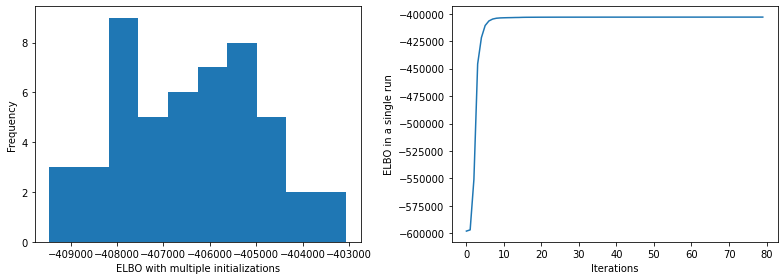

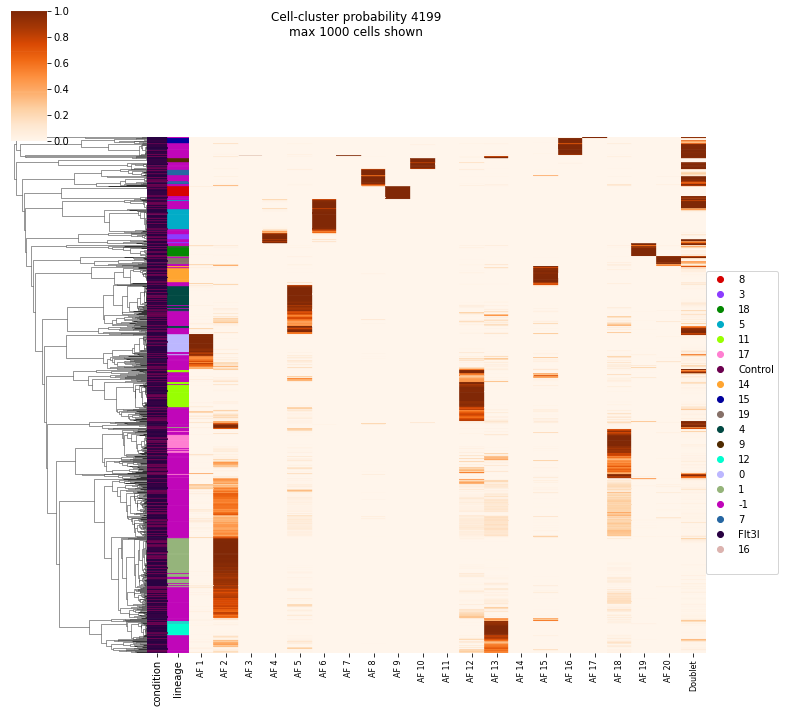

In [10]:
curr_ad_f = join(INDIR, f"cellSNP.tag.AD.mtx")
curr_dp_f = join(INDIR, f"cellSNP.tag.DP.mtx")
curr_vcf_f = join(INDIR, f"cellSNP.base.vcf")
curr_cells_f = join(INDIR, "cellSNP.samples.tsv")


#for donor in np.arange(N_DONORS):
prefix=f"donor{donor}"
model_name = f"donor{donor}_"
#for clone in n_clone_list:
#    cells_meta_col = f"lineage{nclones}"
#     OUTDIR = join(OUTDIR, cells_meta_col)
#     if not exists(OUTDIR):
#         os.mkdir(OUTDIR)
curr_cells_meta = cells_meta.copy()

ic(curr_ad_f)
ic(curr_dp_f)
curr_ad = mmread(curr_ad_f).tocsc()
curr_dp = mmread(curr_dp_f).tocsc() 
curr_vcf = pd.read_csv(curr_vcf_f, sep='\t')
cells = pd.read_csv(curr_cells_f, sep='\t', header=None)
curr_cells_meta = curr_cells_meta.loc[curr_cells_meta["ID"].isin(cells[0])]
ic(curr_vcf.head())
ic(curr_cells_meta.shape)
#model_name = f"lineage_{nclones}"
modelCA, elbo = run_vireo(curr_ad, curr_dp, nclones, n_cores=n_cores, plot_qc=True,out_f=join(OUTDIR, prefix))
try:
    doublet_prob = modelCA.predict_doublet(curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)
except AttributeError: # New version of Vireo 2021
    #doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
    doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA, curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)


separate_donors(curr_ad, curr_dp, modelCA, curr_cells_meta, OUTDIR,
                doublet_prob,
                prob_thresh=0.9, doublet_thresh=0.9,
                cells_ind_col='donor_index',
                out_name="lineage", prefix=model_name, cells_filt_col="donor", 
                cells_filt_val=donor, vars_meta=curr_vcf)   
lin_cells_meta = pd.read_csv(join(OUTDIR, f"{prefix}_cells_meta.tsv"), sep='\t')
ic(lin_cells_meta.head())
ic(lin_cells_meta.shape)
ic("Plotting AF SNPs")
lin_cells_meta = lin_cells_meta.astype({"lineage": 'Int64'}).fillna(-1).astype(str)
plot_vireo_out(modelCA, out_f=join(OUTDIR, prefix), 
               labels=lin_cells_meta[["condition", "lineage"]], 
               doublet_prob=doublet_prob)

plt.close()

#lin_cells_meta.to_csv(join(OUTDIR, ))
